In [18]:
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import InceptionV3, decode_predictions

In [15]:
img = io.imread(
    'http://farm5.static.flickr.com/4345/36875361391_0ea93dd5bb.jpg'
)
img = transform.resize(img, (299, 299, 3))
img = np.asarray([img,])

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


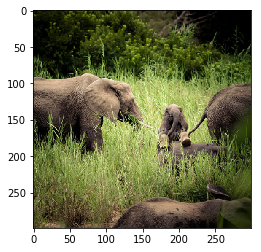

In [11]:
plt.imshow(img)
plt.show()

In [8]:
model = InceptionV3()

93536256/96112376 [============================>.] - ETA: 0s  

In [19]:
decode_predictions(model.predict(img), top=3)

24576/35363 [===================>..........] - ETA: 0s

[[('n02504458', 'African_elephant', 0.97451222),
  ('n01871265', 'tusker', 0.015076204),
  ('n02504013', 'Indian_elephant', 0.0021278877)]]